# MNIST Classification using  neural networks

### Import modules

In [82]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import pathlib
from time import time
from collections import defaultdict

### Download MNIST data and pre process it

In [83]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomInvert()])
train_set = datasets.MNIST(root='data',train=True,transform=transform,download=True)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_set = datasets.MNIST(root='data',train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=True)

### Define a cnn based model with a dense network at the end

In [84]:
# conv layers of the network
class CNN(nn.Module):
    def __init__(self, channels, nf):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=nf, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=nf, out_channels=2*nf, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=2*nf, out_channels=4*nf, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.bn_conv = nn.BatchNorm2d(nf)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)

        x = self.conv3(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)

        return x

# dense layers of the network
class FCNN(nn.Module):
    def __init__(self, nf, num_classes):
        super(FCNN, self).__init__()
        # in: nfx4x4, flatten and feed to linear layer
        self.fc1 = nn.Linear(4*nf*3*3, 4*nf)
        self.bn_d1 = nn.BatchNorm1d(4*nf)
        self.fc2 = nn.Linear(4*nf, nf)
        self.bn_d2 = nn.BatchNorm1d(nf)        
        self.fc3 = nn.Linear(nf, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_d1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn_d2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.fc3(x)
        #x = self.bn_d3(x)
        return x

# combined model
class MODEL(nn.Module):
    def __init__(self, channels, nf, num_classes):
        super(MODEL, self).__init__()
        self.conv = CNN(channels, nf)
        self.dense = FCNN(nf, num_classes)
        self.nf = nf
        self.channels = channels
    
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.dense(x)
        return x

### Util functions, model related

In [85]:
# A util function to print model summary
def print_model_summary(model):
    print(summary(model.conv, input_size=(1,28,28)))
    print(summary(model.dense, input_size=(1, 4*model.nf * 3*3)))

def count_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Toatal model params: {total_params}, Trainable params: {trainable_params}")
    return total_params, trainable_params

def save_plots(losses, name=None):
    pathlib.Path("results").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_plot_path = "results/plot-"+timestr
    else:
        save_plot_path = "results/"+name
    epochs = len(losses['train_loss'])
    plt.plot(range(1,epochs+1), losses['train_loss'], label='Train loss')
    plt.plot(range(1,epochs+1), losses['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"MNIST Losses")
    plt.savefig(save_plot_path, facecolor='w', edgecolor='none')
    plt.show()

def save_model(model, name=None):
    pathlib.Path("results/saved_models").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_model_path = "results/saved_models/VAE_MNIST-"+timestr+".pth"
    else:
        save_model_path = "results/saved_models/"+name+".pth"
    torch.save(model.state_dict(), save_model_path)

# load model
def load_model(model_name, model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    model_path = "results/saved_models/"+model_name+".pth"
    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
    except OSError as e:
        print(f"{e.strerror}: {e.filename}")
        return None
    return model

In [86]:
# check if output shape is as expected
test_model = MODEL(1,16,10) #MODEL(3,10)
test_input = torch.randn(size=(64,1,28,28))
output = test_model(test_input)
output.shape
print_model_summary(test_model)


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 3, 3]                32
├─Conv2d: 1-1                            [16, 28, 28]              160
├─MaxPool2d: 1-2                         [16, 14, 14]              --
├─Conv2d: 1-3                            [32, 14, 14]              4,640
├─MaxPool2d: 1-4                         [32, 7, 7]                --
├─Conv2d: 1-5                            [64, 7, 7]                18,496
├─MaxPool2d: 1-6                         [64, 3, 3]                --
Total params: 23,328
Trainable params: 23,328
Non-trainable params: 0
Total mult-adds (M): 10.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.09
Estimated Total Size (MB): 0.27
Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   36,

### Define train and test functions

In [87]:
def train_model(model, device, train_loader, loss_criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    total = 0
    total_acc = 0
    for batchidx, (data, target) in enumerate(train_loader):
        #print(f'batch id: {batchidx}')
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        #print(f'predictions: {predictions.shape}, target: {target.shape}')
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        total_acc += (correct/len(data))
        total += len(data)
    avg_acc = total_acc/len(train_loader)
    avg_loss = train_loss/total
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\tAcc: {100. * avg_acc:.6f}%")
    return 100. * avg_acc, avg_loss

def test_model(model, device, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item()
            predictions = output.argmax(dim=1, keepdim=True)
            #print(f'predictions: {predictions.shape}, target: {target.shape}')
            correct += predictions.eq(target.view_as(predictions)).sum().item()
            total += len(data)
    test_loss /= total
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({100. * correct/total:.0f}%)")
    return 100. * correct/total, test_loss


### Train and plot loss curves

Train epoch: 1 [59968/60000          (100%)]	Loss: 0.006555	Acc: 86.906350%
Test set: Average loss: 0.0029, Accuracy: 9462/9984 (95%)
Train epoch: 2 [59968/60000          (100%)]	Loss: 0.002854	Acc: 94.907284%
Test set: Average loss: 0.0012, Accuracy: 9763/9984 (98%)
Train epoch: 3 [59968/60000          (100%)]	Loss: 0.002471	Acc: 95.664354%
Test set: Average loss: 0.0009, Accuracy: 9808/9984 (98%)
Train epoch: 4 [59968/60000          (100%)]	Loss: 0.002186	Acc: 96.229656%
Test set: Average loss: 0.0008, Accuracy: 9846/9984 (99%)
Train epoch: 5 [59968/60000          (100%)]	Loss: 0.001994	Acc: 96.524813%
Test set: Average loss: 0.0008, Accuracy: 9849/9984 (99%)
Train epoch: 6 [59968/60000          (100%)]	Loss: 0.001848	Acc: 96.696572%
Test set: Average loss: 0.0007, Accuracy: 9855/9984 (99%)
Train epoch: 7 [59968/60000          (100%)]	Loss: 0.001828	Acc: 96.693236%
Test set: Average loss: 0.0006, Accuracy: 9865/9984 (99%)
Train epoch: 8 [59968/60000          (100%)]	Loss: 0.001624	Ac

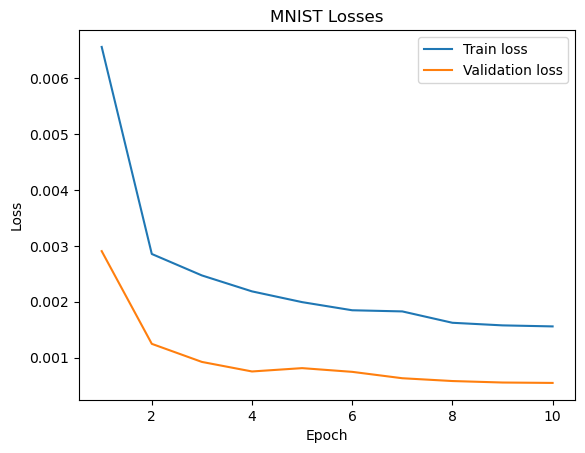

In [88]:
num_classes = 10
num_filters = 16
learning_rate = 0.01
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_criterion = nn.CrossEntropyLoss()
inp_channels = 1
model = MODEL(inp_channels, num_filters, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

losses = defaultdict(list)

for epoch in range(1,num_epochs+1):
    _, tloss = train_model(model, device, train_loader, loss_criterion, optimizer, epoch)
    losses['train_loss'].append(tloss)
    _, vloss = test_model(model, device, test_loader, loss_criterion)
    losses['val_loss'].append(vloss)

# save plots
save_plots(losses, 'mnist-loss')

#save model
save_model(model, 'mnist_sample_model')

### Make prediction

torch.Size([64, 10])


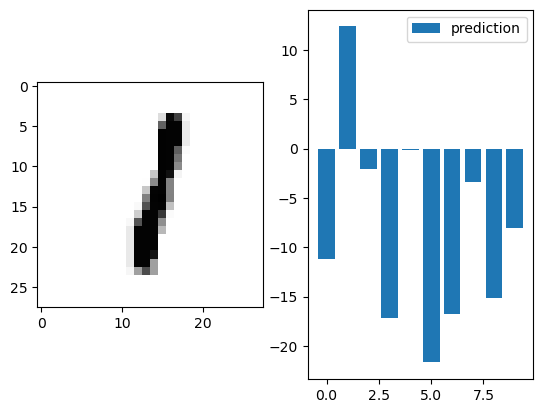

<Figure size 100x100 with 0 Axes>

In [89]:
inputs, labels = next(iter(train_loader))
outs = model(inputs)
idx = 2
print(outs.shape)
im = inputs[idx]
im = torch.einsum('chw->hwc',[im])
fig, axs = plt.subplots(1,2)
plt.figure(figsize=(1,1))
axs[0].imshow(im, cmap='Greys')
axs[1].bar(range(10), outs[idx].detach().cpu(), label='prediction')
axs[1].legend()